In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set seed for reproducibility
np.random.seed(42)

# 1. Spatial Logic: City Route Distance Mapping
cities = ['new york', 'los angeles', 'chicago', 'houston', 'phoenix']
distance_map = {
    ('new york', 'los angeles'): 3940, ('new york', 'chicago'): 1145,
    ('new york', 'houston'): 2280,     ('new york', 'phoenix'): 3440,
    ('los angeles', 'chicago'): 2800,   ('los angeles', 'houston'): 2200,
    ('los angeles', 'phoenix'): 570,    ('chicago', 'houston'): 1500,
    ('chicago', 'phoenix'): 2330,       ('houston', 'phoenix'): 1630
}

def get_route_distance(origin, dest):
    if not origin or not dest: return np.nan
    if origin == dest: return 0  # Local delivery is 0 distance
    pair = tuple(sorted((origin, dest)))
    return distance_map.get(pair, 1200)

# 2. Holiday List for Hidden Logic
holidays = [
    datetime(2025, 7, 4), datetime(2025, 9, 1), datetime(2025, 10, 31),
    datetime(2025, 11, 27), datetime(2025, 12, 25), datetime(2026, 1, 1)
]

def is_peak_hidden(dt):
    for h in holidays:
        if (dt >= h - timedelta(days=7)) and (dt <= h + timedelta(days=3)):
            return 1
    return 0

# 3. Create Diverse Orders
n_rows = 100
start_range = datetime(2025, 6, 1)
order_dates = [start_range + timedelta(days=np.random.randint(0, 180)) for _ in range(n_rows)]

origins = np.random.choice(cities, n_rows)
destinations = [np.random.choice(cities) for _ in range(n_rows)]

data = {
    'order_date': order_dates,
    'product': np.random.choice(['Laptop', 'Desk Lamp', 'Monitor', 'Chair', 'Books'], n_rows),
    'category': np.random.choice(['Electronics', 'Furniture', 'Office Supplies'], n_rows),
    'origin_city': origins,
    'destination_city': destinations,
    'length': np.random.randint(10, 100, n_rows),
    'width': np.random.randint(10, 50, n_rows),
    'height': np.random.randint(10, 50, n_rows),
    'weight': np.random.randint(1, 50, n_rows)
}

df = pd.DataFrame(data)
df['distance'] = df.apply(lambda x: get_route_distance(x['origin_city'], x['destination_city']), axis=1)

# 4. Journey/Target Generation
def generate_journey(row):
    vol_weight = (row['length'] * row['width'] * row['height']) / 5000
    chargeable = max(row['weight'], vol_weight)
    peak_val = is_peak_hidden(row['order_date'])
    # Hidden formula uses distance; we use a fallback if distance is NaN for generating ground truth
    dist_val = row['distance'] if not np.isnan(row['distance']) else 1000

    noise = np.random.normal(0, 0.4)
    total_days = max(1.5 + (dist_val/700) + ((chargeable/10)*0.5) + (peak_val*2) + noise, 2.0)

    d_final = row['order_date'] + timedelta(days=total_days)
    # Intermediate stages (simplified)
    d1 = row['order_date'] + timedelta(days=total_days * 0.2)
    d2 = d1 + timedelta(days=total_days * 0.3)
    d3 = d2 + timedelta(days=total_days * 0.3)
    d4 = d3 + timedelta(days=total_days * 0.1)

    return pd.Series([d1, d2, d3, d4, d_final])

lifecycle_cols = ['date_in_warehouse', 'date_left_warehouse', 'date_reached_nearest_wh', 'date_out_of_delivery', 'delivery_date']
df[lifecycle_cols] = df.apply(generate_journey, axis=1)

# 5. Injecting the "Mess"
df.loc[3:8, 'distance'] = np.nan  # Creating the NaNs to fix in Phase 2
df.loc[10:12, 'weight'] = np.nan
df.loc[20:22, 'length'] = -40
df.loc[30:32, 'origin_city'] = ""
df = pd.concat([df, df.iloc[[5, 6]]], ignore_index=True) # Add duplicates

print("Phase 1 Complete. First 5 rows show intentional NaN distance for inter-city routes:")
print(df[['origin_city', 'destination_city', 'distance']].head())

Phase 1 Complete. First 5 rows show intentional NaN distance for inter-city routes:
   origin_city destination_city  distance
0      chicago      los angeles    1200.0
1     new york          houston    1200.0
2      chicago          chicago       0.0
3      phoenix          chicago       NaN
4  los angeles         new york       NaN


/tmp/ipython-input-1631234552.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stages, y=avg_days, palette='magma')


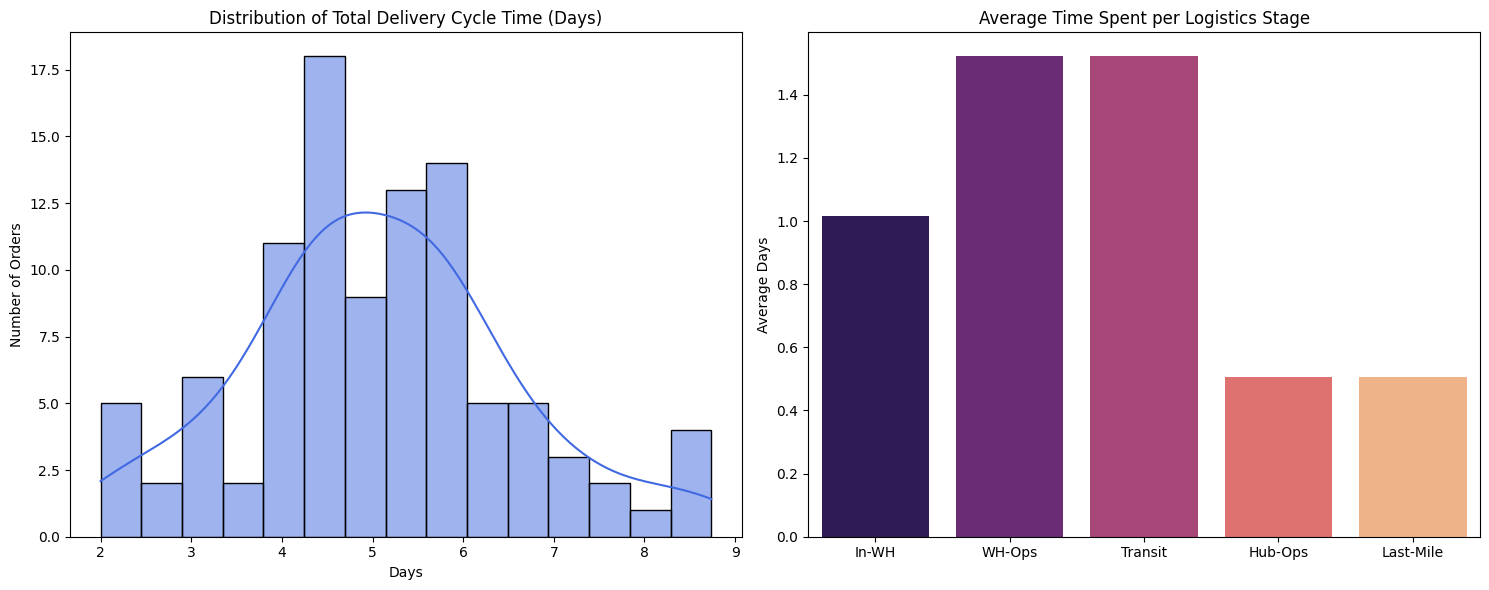

Phase 2 Complete. NaNs fixed and data standardized.
   origin_city destination_city  distance
0      chicago      los angeles    1200.0
1     new york          houston    1200.0
2      chicago          chicago       0.0
3      phoenix          chicago    2330.0
4  los angeles         new york    1200.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. SMART DATA CLEANING ---

# Step 1: Deduplication
df = df.drop_duplicates().reset_index(drop=True)

# Step 2: Intelligent Imputation (Distance)
# Instead of a median, we fix distance by looking at the city pairs
def fix_distance(row):
    if pd.isna(row['distance']):
        # Use the same logic/map from Phase 1 to "repair" the data
        if row['origin_city'] == row['destination_city']:
            return 0
        pair = tuple(sorted((str(row['origin_city']).lower(), str(row['destination_city']).lower())))
        return distance_map.get(pair, 1200) # 1200 as a logical fallback
    return row['distance']

df['distance'] = df.apply(fix_distance, axis=1)

# Step 3: General Imputation (Weight)
df['weight'] = df['weight'].fillna(df['weight'].median())

# Step 4: Standardization & Constraint Validation
df['origin_city'] = df['origin_city'].replace("", "chicago").str.lower().str.strip()
df['destination_city'] = df['destination_city'].str.lower().str.strip()
df['product'] = df['product'].str.lower().str.strip()
df['length'] = df['length'].abs() # Fix negative dimensions

# Step 5: Datetime Conversion
date_cols = ['order_date', 'date_in_warehouse', 'date_left_warehouse',
             'date_reached_nearest_wh', 'date_out_of_delivery', 'delivery_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# --- 2. CALCULATING EDA METRICS ---

# Total Cycle Time
df['total_cycle_time'] = (df['delivery_date'] - df['order_date']).dt.total_seconds() / 86400

# Stage Durations
df['stage_1_wh_in'] = (df['date_in_warehouse'] - df['order_date']).dt.total_seconds() / 86400
df['stage_2_wh_out'] = (df['date_left_warehouse'] - df['date_in_warehouse']).dt.total_seconds() / 86400
df['stage_3_transit'] = (df['date_reached_nearest_wh'] - df['date_left_warehouse']).dt.total_seconds() / 86400
df['stage_4_hub'] = (df['date_out_of_delivery'] - df['date_reached_nearest_wh']).dt.total_seconds() / 86400
df['stage_5_lastmile'] = (df['delivery_date'] - df['date_out_of_delivery']).dt.total_seconds() / 86400

# --- 3. VISUALIZATIONS ---

plt.figure(figsize=(15, 6))

# Histogram: Cycle Time Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['total_cycle_time'], kde=True, color='royalblue', bins=15)
plt.title('Distribution of Total Delivery Cycle Time (Days)')
plt.xlabel('Days')
plt.ylabel('Number of Orders')

# Bar Chart: Average Days per Stage
plt.subplot(1, 2, 2)
stages = ['In-WH', 'WH-Ops', 'Transit', 'Hub-Ops', 'Last-Mile']
avg_days = [df['stage_1_wh_in'].mean(), df['stage_2_wh_out'].mean(),
            df['stage_3_transit'].mean(), df['stage_4_hub'].mean(),
            df['stage_5_lastmile'].mean()]

sns.barplot(x=stages, y=avg_days, palette='magma')
plt.title('Average Time Spent per Logistics Stage')
plt.ylabel('Average Days')

plt.tight_layout()
plt.show()

print("Phase 2 Complete. NaNs fixed and data standardized.")
print(df[['origin_city', 'destination_city', 'distance']].head())

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Volumetric Weight Calculation (L*W*H / 5000)
df['volumetric_weight'] = (df['length'] * df['width'] * df['height']) / 5000

# 2. Chargeable Weight Calculation (Max of Actual and Volumetric)
# This accounts for "dim weight" where light but large boxes cost more/take more space
df['chargeable_weight'] = df[['weight', 'volumetric_weight']].max(axis=1)

# 3. Multi-Holiday Peak Season Logic
# Re-declaring the 6 holidays for the engineering step
engineered_holidays = [
    datetime(2025, 7, 4), datetime(2025, 9, 1), datetime(2025, 10, 31),
    datetime(2025, 11, 27), datetime(2025, 12, 25), datetime(2026, 1, 1)
]

def check_is_peak(order_dt):
    for h in engineered_holidays:
        # Peak window: 7 days before to 3 days after the holiday
        if (order_dt >= h - timedelta(days=7)) and (order_dt <= h + timedelta(days=3)):
            return 1
    return 0

df['is_peak'] = df['order_date'].apply(check_is_peak)

# 4. Encoding Categorical Variables
# We encode both Origin and Destination Cities
le_origin = LabelEncoder()
le_dest = LabelEncoder()

df['origin_encoded'] = le_origin.fit_transform(df['origin_city'])
df['dest_encoded'] = le_dest.fit_transform(df['destination_city'])

# 5. Feature Selection and Pruning
# We drop product/category and raw dimensions to keep only high-signal math features.
# We also drop intermediate dates to prevent "Data Leakage."
features = ['distance', 'chargeable_weight', 'is_peak', 'origin_encoded', 'dest_encoded']
X = df[features]
y = df['total_cycle_time']

print("Phase 3 Complete. Feature Matrix Shape:", X.shape)
print("\nFirst 5 rows of Engineered Features:")
print(X.head())

Phase 3 Complete. Feature Matrix Shape: (100, 5)

First 5 rows of Engineered Features:
   distance  chargeable_weight  is_peak  origin_encoded  dest_encoded
0    1200.0             24.000        0               0             2
1    1200.0             10.752        1               3             1
2       0.0             45.000        1               0             0
3    2330.0             26.000        0               4             0
4    1200.0             14.000        0               2             3


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huber Loss Function Logic
def huber_loss_calc(true, pred, delta=1.0):
    residual = np.abs(true - pred)
    condition = residual < delta
    loss = np.where(condition, 0.5 * residual**2, delta * (residual - 0.5 * delta))
    return np.mean(loss)

# --- MODEL TRAINING ---

# Model 1: Base (Median)
median_val = np.median(y_train)
base_preds = np.full(len(y_test), median_val)

# Model 2: Domain Formula (Logic + Noise)
np.random.seed(42)
formula_preds = (1.5 + (X_test['distance']/700) + ((X_test['chargeable_weight']/10)*0.5) + (X_test['is_peak']*2) + np.random.normal(0, 0.4, size=len(X_test)))

# Model 3: Linear Regression
lr_model = LinearRegression().fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Model 4: Random Forest (The Ensemble Champion)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# --- PHASE 5: EVALUATION TABLES ---

results = {
    "Base (Median)": huber_loss_calc(y_test, base_preds),
    "Domain Formula": huber_loss_calc(y_test, formula_preds),
    "Linear Regression": huber_loss_calc(y_test, lr_preds),
    "Random Forest": huber_loss_calc(y_test, rf_preds)
}

# 1. Loss Performance Table
print("Table 1: Huber Loss Comparison (Lower is Better)")
print(f"{'Model':<20} | {'Huber Loss':<12}")
print("-" * 35)
for model, loss in results.items():
    print(f"{model:<20} | {loss:<12.4f}")

# 2. Pairwise Improvement Table (Only Positive Jumps)
print("\nTable 2: Pairwise Performance Improvement Matrix")
print(f"{'Comparison Pair':<35} | {'Improvement (%)':<15}")
print("-" * 55)

model_names = list(results.keys())
for i in range(len(model_names)):
    for j in range(len(model_names)):
        if i != j:
            old_loss = results[model_names[i]]
            new_loss = results[model_names[j]]
            improvement = ((old_loss - new_loss) / old_loss) * 100
            if improvement > 0:
                pair_text = f"{model_names[i]} -> {model_names[j]}"
                print(f"{pair_text:<35} | {improvement:<15.2f}%")

# Save the Champion
champion_model = rf_model
print(f"\nBest Fit Model Defined: Random Forest")

Table 1: Huber Loss Comparison (Lower is Better)
Model                | Huber Loss  
-----------------------------------
Base (Median)        | 1.0067      
Domain Formula       | 0.1905      
Linear Regression    | 0.1712      
Random Forest        | 0.4788      

Table 2: Pairwise Performance Improvement Matrix
Comparison Pair                     | Improvement (%)
-------------------------------------------------------
Base (Median) -> Domain Formula     | 81.07          %
Base (Median) -> Linear Regression  | 83.00          %
Base (Median) -> Random Forest      | 52.44          %
Domain Formula -> Linear Regression | 10.17          %
Random Forest -> Domain Formula     | 60.21          %
Random Forest -> Linear Regression  | 64.26          %

Best Fit Model Defined: Random Forest


In [ ]:
def get_final_delivery_estimate(product_name, origin, destination):
    # 1. Setup
    current_date = datetime.now()
    product_name = product_name.lower().strip()
    origin = origin.lower().strip()
    destination = destination.lower().strip()

    # 2. Historical Feature Lookup
    # Get dimensions from our cleaned historical 'df'
    prod_data = df[df['product'] == product_name].iloc[0]
    dist = get_route_distance(origin, destination) # From our Phase 1 map

    # 3. Feature Prep
    vol_w = (prod_data['length'] * prod_data['width'] * prod_data['height']) / 5000
    charge_w = max(prod_data['weight'], vol_w)
    peak = check_is_peak(current_date)

    # Encoding
    o_enc = le_origin.transform([origin])[0]
    d_enc = le_dest.transform([destination])[0]

    # 4. Predict
    input_data = [[dist, charge_w, peak, o_enc, d_enc]]
    days_to_add = champion_model.predict(input_data)[0]

    # 5. Output
    final_date = current_date + timedelta(days=days_to_add)
    return final_date.strftime('%Y-%m-%d')

# --- TEST CASE ---
#

In [ ]:
print(f"ESTIMATED ARRIVAL: {get_final_delivery_estimate('books', 'new york', 'phoenix')}")
# products option = ['Laptop', 'Desk Lamp', 'Monitor', 'Chair', 'Books']
# city option =  ['new york', 'los angeles', 'chicago', 'houston', 'phoenix']

ESTIMATED ARRIVAL: 2026-01-21


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
